# Tutorial 5 - Options Intro

Please complete this tutorial to get an overview of options and an implementation of SMDP Q-Learning and Intra-Option Q-Learning.


### References:

 [Recent Advances in Hierarchical Reinforcement
Learning](https://people.cs.umass.edu/~mahadeva/papers/hrl.pdf) is a strong recommendation for topics in HRL that was covered in class. Watch Prof. Ravi's lectures on moodle or nptel for further understanding the core concepts. Contact the TAs for further resources if needed. 


In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import gym
from tqdm import tqdm
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns

In [2]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
env = CliffWalkingEnv()

env.reset()

#Current State
print(env.s)

# 4x12 grid = 48 states
print ("Number of states:", env.nS)

# Primitive Actions
action = ["up", "right", "down", "left"]
#correspond to [0,1,2,3] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob, _ = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
# env.render()

36
Number of states: 48
Number of actions that an agent can take: 4
Action taken: left
Transition probability: False
Next state: 36
Reward recieved: -1
Terminal state: False


#### Options
We custom define very simple options here. They might not be the logical options for this settings deliberately chosen to visualise the Q Table better.


In [3]:
# We are defining two more options here
# Option 1 ["Away"] - > Away from Cliff (ie keep going up)
# Option 2 ["Close"] - > Close to Cliff (ie keep going down) 

def Away(env,state):
    
    optdone = False
    optact = 0
    
    if (int(state/12) == 0):
        optdone = True
    
    return [optact,optdone]
    
def Close(env,state):
    
    optdone = False
    optact = 2
    
    if (int(state/12) == 3):
        optdone = True
    
    return [optact,optdone]
    
    
'''
Now the new action space will contain
Primitive Actions: ["up", "right", "down", "left"]
Options: ["Away","Close"]
Total Actions :["up", "right", "down", "left", "Away", "Close"]
Corresponding to [0,1,2,3,4,5]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["up", "right", "down", "left"]\nOptions: ["Away","Close"]\nTotal Actions :["up", "right", "down", "left", "Away", "Close"]\nCorresponding to [0,1,2,3,4,5]\n'

# Task 1
Complete the code cell below


In [4]:
#Update_Frequency Data structure? Check TODO 4

# TODO: epsilon-greedy action selection function
def egreedy_policy(q_values,state,epsilon):
    best = np.argmax(q_values[state, :])
#     print(best)
    
    choice = None
    p = np.random.binomial(1, 1-epsilon)
    if p == 0: choice = np.random.choice(range(len(q_values[state,:])))
    else: choice = best
        
    return choice

# Task 2
Below is an incomplete code cell with the flow of SMDP Q-Learning. Complete the cell and train the agent using SMDP Q-Learning algorithm.
Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)

In [17]:
#### SMDP Q-Learning 
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_smdp = np.zeros((48,6))

# Add parameters you might need here
gamma = 0.9
alpha = 0.1 # learning rate


# Iterate over 1000 episodes
updates_smdp = []
for ep in tqdm(range(1000)):
    state, _ = env.reset()    
    done = False

    # While episode is not over
    timestep = 0
    updates_smdp.append([])
    while not done:
        
        # Choose action        
        action = egreedy_policy(q_values_smdp, state, epsilon=0.1)
#         print(state, action)
        timestep += 1
        
        # Checking if primitive action
        if action < 4:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done,_,_ = env.step(action)
            q_values_smdp[state, action] += alpha * (reward + gamma* max(q_values_smdp[next_state, :4]) - q_values_smdp[state, action])
            
            state = next_state
            
            
        # Checking if action chosen is an option
        reward_bar, steps, start = 0, 0, state
        rewards = []
        if action == 4: # action => Away option
            
            optdone = False
            while (optdone == False):
                
                # Think about what this function might do?
                optact, optdone = Away(env,state)
                next_state, reward, done,_,_ = env.step(optact)
                
                # Is this formulation right? What is this term?
                # this term calculates the cumulative discounted reward over the entire time period
                rewards.append(reward)
                steps += 1
                
                state = next_state
            
            # Complete SMDP Q-Learning Update
            # Remember SMDP Updates. When & What do you update? 
            for i in range(steps):
                reward_bar += (gamma**i) * rewards[i]
                
            q_values_smdp[start, action] += alpha * (reward_bar + (gamma**steps)*max(q_values_smdp[next_state, 4:]) - q_values_smdp[state, action])
            state = next_state
            timestep += steps-1
                
            
        # Checking if action chosen is an option
        reward_bar, steps, start = 0, 0, state
        rewards = []
        if action == 5: # action => Close option
            
            optdone = False
            while (optdone == False):
                
                # Think about what this function might do?
                optact, optdone = Close(env,state) 
                next_state, reward, done,_,_ = env.step(optact)
                
                # Is this formulation right? What is this term?
                # this term calculates the cumulative discounted reward over the entire time period
                rewards.append(reward)
                steps += 1
            
                state = next_state
            
            # Complete SMDP Q-Learning Update
            # Remember SMDP Updates. When & What do you update? 
            for i in range(steps):
                reward_bar += (gamma**i) * rewards[i]
                
            q_values_smdp[start, action] += alpha * (reward_bar + (gamma**steps)*max(q_values_smdp[next_state, 4:]) - q_values_smdp[state, action])
            state = next_state
            timestep += steps-1
            
        updates_smdp[-1].append(timestep)
#     print('Episode',ep,'Completed !')

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2034.48it/s]


# Task 3
Using the same options and the SMDP code, implement Intra Option Q-Learning (In the code cell below). You *might not* always have to search through options to find the options with similar policies, think about it. Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)



In [18]:
#### Intra-Option Q-Learning 

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_intop = np.zeros((48,6))

# Add parameters you might need here
gamma = 0.9
alpha = 0.1


# Iterate over 1000 episodes
updates_intop = []
for ep in tqdm(range(1000)):
    state, _ = env.reset()    
    done = False

    # While episode is not over
    timestep = 0
    updates_intop.append([])
    while not done:
        
        # Choose action        
        action = egreedy_policy(q_values_intop, state, epsilon=0.1)
#         print(state, action)
        timestep += 1
        
        # Checking if primitive action
        if action < 4:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done,_,_ = env.step(action)
            q_values_intop[state, action] += alpha * (reward + gamma* max(q_values_intop[next_state, :4]) - q_values_intop[state, action])
            
            updates_intop[-1].append(timestep)
            state = next_state
            
            
        # Checking if action chosen is an option
        steps, start = 0, state
        if action == 4: # action => Away option
            
            optdone = False
            while (optdone == False):
                
                # Think about what this function might do?
                optact, optdone = Away(env,state)
                next_state, reward, done,_,_ = env.step(optact)
                
                if optdone: break
                
                # updateing within the option loop for Intra-Option Learning
                q_values_intop[state, action] += alpha * (reward + gamma*q_values_intop[next_state, action] - q_values_intop[state, action])
                updates_intop[-1].append(timestep + steps)
                steps += 1
                
                state = next_state
            
            q_values_intop[state, action] += alpha * (reward + gamma*max(q_values_intop[next_state, :4]) - q_values_intop[state, action])
            timestep += steps-1
            updates_intop[-1].append(timestep)
                
            
        # Checking if action chosen is an option
        steps, start = 0, state
        if action == 5: # action => Close option
            
            optdone = False
            while (optdone == False):
                
                # Think about what this function might do?
                optact, optdone = Close(env,state)
                next_state, reward, done,_,_ = env.step(optact)
                
                if optdone: break
                
                # updateing within the option loop for Intra-Option Learning
                q_values_intop[state, action] += alpha * (reward + gamma*q_values_intop[next_state, action] - q_values_intop[state, action])
                updates_intop[-1].append(timestep + steps)
                steps += 1
                
                state = next_state
            
            q_values_intop[state, action] += alpha * (reward + gamma*max(q_values_intop[next_state, :4]) - q_values_intop[state, action])
            timestep += steps-1
            updates_intop[-1].append(timestep)

#     print('Episode',ep,'Completed !')

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1951.07it/s]


# Task 4
Compare the two Q-Tables and Update Frequencies and provide comments.

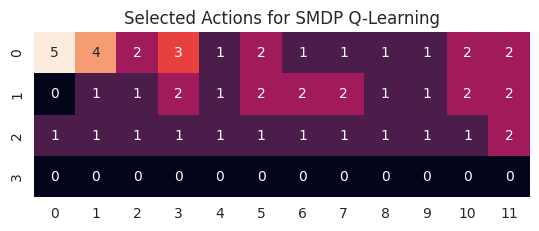

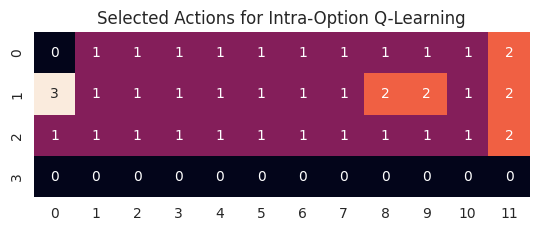

In [19]:
sns.heatmap(np.argmax(q_values_smdp, axis = 1).reshape(4,12), annot=True, square=True, cbar = False)
plt.title('Selected Actions for SMDP Q-Learning')
plt.show()
sns.heatmap(np.argmax(q_values_intop, axis = 1).reshape(4,12), annot=True, square=True, cbar = False)
plt.title('Selected Actions for Intra-Option Q-Learning')
plt.show()

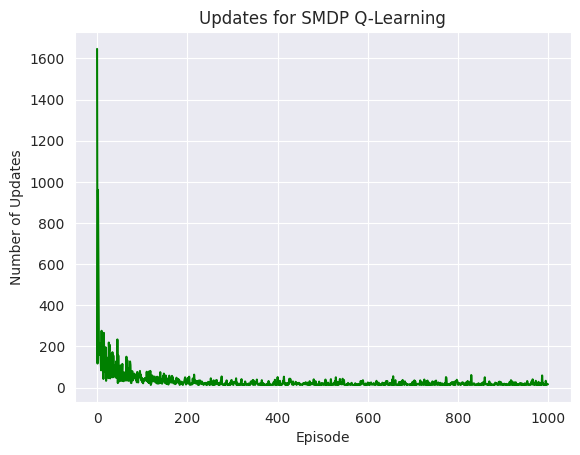

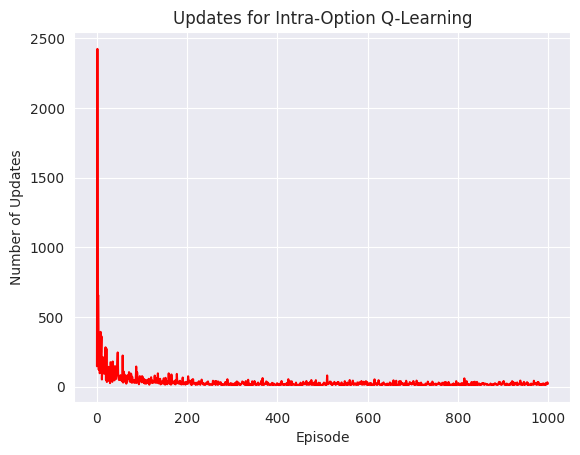

In [20]:
sns.set_style('darkgrid')
mx1, mx2 = [], []
for i in range(1000):
    mx1.append(len(updates_smdp[i]))
    mx2.append(len(updates_intop[i]))
    
plt.figure()
plt.plot(np.arange(1000), np.array(mx1), 'g')
plt.xlabel('Episode')
plt.ylabel('Number of Updates')
plt.title('Updates for SMDP Q-Learning')
plt.show()

plt.figure()
plt.plot(np.arange(1000), np.array(mx2), 'r')
plt.xlabel('Episode')
plt.ylabel('Number of Updates')
plt.title('Updates for Intra-Option Q-Learning')
plt.show()

The following can be observed:

 - The number of updates is significantly higher in Intra-Option Learning 
 - This makes sense since a large number of updates are being performed within the options
 - This property was seen in a number of reruns
 
 - From the start state, both learning techniques give us an optimal policy to reach the goal state
 - This is done while ensuring that the agent does not "fall off the cliff"